In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from IPython.display import display
import os
import pickle

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve, precision_recall_curve, confusion_matrix, classification_report, average_precision_score
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

# binning
try:
    from optbinning import OptimalBinning
except:
    ! pip install optbinning
    from optbinning import OptimalBinning

# silence warnings
import warnings
warnings.filterwarnings('ignore')


(CVXPY) Feb 19 03:47:06 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 19 03:47:06 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# File path

file_path = r'M:/Risk Management/DW/Scorecard/Capacity Model Input Files/Capacity_Data_CT.csv'

In [3]:
# Read in training file

df = pd.read_csv(file_path, low_memory=False)

## EDA - Reduce Data Frame to Initial Informative Features

In [4]:
# Specify columns to drop on df subset

cols_to_keep = [
    'BIGACCOUNTID',
    'APPLICATIONDATE',
    'SUM_OF_COMBINED_INCOME',
    'PAYMENT',
    'INT_N_EMPS',
    'PTI',
    'LTV',
    'FLTADVANCE',
    'TOTAL_INCOME',
    'FLTDOWNCASH',
    'VEHICLEYEAR',
    'BIGMILEAGE_ODOMETER',
    'DTI',
    'NUMOFDEBTS',
    'BITTARGET24MONTHS',

    'INQUIRYBANKING12MONTH',
    'INQUIRYAUTO12MONTH',
    'INQUIRYCOLLECTIONS12MONTH',
    'ADDRCHANGECOUNT06MONTH',
    'ADDRCHANGECOUNT12MONTH',
    'ADDRCHANGECOUNT24MONTH',
    'ADDRCHANGECOUNT60MONTH',
    'ADDRCURRENTLENGTHOFRES',
    'ADDRCURRENTTIMENEWEST',
    'ADDRCURRENTTIMEOLDEST',
    'ADDRINPUTTIMENEWEST',
    'ADDRINPUTTIMEOLDEST',
    'ADDRINPUTLENGTHOFRES',
    'ADDRPREVIOUSLENGTHOFRES',
    'CONFIRMATIONINPUTADDRESS',
    'ADDRINPUTSUBJECTCOUNT',
    'EVICTIONCOUNT',
    'ADDRSTABILITYINDEX',
    'ADDRONFILECOUNT',

    'ADDRINPUTMATCHINDEX',
    'ADDRINPUTOWNERSHIPINDEX',
    'ASSETPROP'
    
]


In [5]:
# Subset df to cols to keep

df = df[cols_to_keep]

#### Determine missing % for each feature, target

In [6]:
# Compute missing percentage for each column

missing_percentage = df.isnull().sum() / len(df) * 100

In [7]:
# Filter columns with more than x% missing values

threshold = 0
missing_above_threshold = missing_percentage[missing_percentage >= threshold]
missing_above_threshold = missing_above_threshold.sort_values(ascending=False)
print(missing_above_threshold)


INT_N_EMPS                   8.082181
TOTAL_INCOME                 8.082181
SUM_OF_COMBINED_INCOME       5.013982
DTI                          2.027342
LTV                          2.015691
BIGMILEAGE_ODOMETER          1.425353
ADDRCHANGECOUNT06MONTH       0.854435
CONFIRMATIONINPUTADDRESS     0.854435
ADDRCURRENTTIMEOLDEST        0.854435
ADDRINPUTTIMENEWEST          0.854435
ADDRINPUTTIMEOLDEST          0.854435
ADDRINPUTLENGTHOFRES         0.854435
ADDRPREVIOUSLENGTHOFRES      0.854435
EVICTIONCOUNT                0.854435
ADDRINPUTSUBJECTCOUNT        0.854435
ADDRCURRENTLENGTHOFRES       0.854435
ADDRSTABILITYINDEX           0.854435
ADDRONFILECOUNT              0.854435
ADDRINPUTMATCHINDEX          0.854435
ADDRINPUTOWNERSHIPINDEX      0.854435
ADDRCURRENTTIMENEWEST        0.854435
ASSETPROP                    0.854435
ADDRCHANGECOUNT60MONTH       0.854435
ADDRCHANGECOUNT24MONTH       0.854435
ADDRCHANGECOUNT12MONTH       0.854435
INQUIRYCOLLECTIONS12MONTH    0.854435
INQUIRYAUTO1

#### Convert APPLICATIONDATE to date time format to split Train, Valid, Test

In [8]:
# Convert application date column to datetime

df['APPLICATIONDATE'] = pd.to_datetime(df['APPLICATIONDATE'].astype(str), format='%Y%m%d')

In [9]:
# Sort data set into chronological order
df = df.sort_values(by='APPLICATIONDATE')

df.head()

,BIGACCOUNTID,APPLICATIONDATE,SUM_OF_COMBINED_INCOME,PAYMENT,INT_N_EMPS,PTI,LTV,FLTADVANCE,TOTAL_INCOME,FLTDOWNCASH,...,ADDRINPUTLENGTHOFRES,ADDRPREVIOUSLENGTHOFRES,CONFIRMATIONINPUTADDRESS,ADDRINPUTSUBJECTCOUNT,EVICTIONCOUNT,ADDRSTABILITYINDEX,ADDRONFILECOUNT,ADDRINPUTMATCHINDEX,ADDRINPUTOWNERSHIPINDEX,ASSETPROP
35085,5466262,2021-01-01,6413.339844,468.53,2.0,0.146111,1.3910,1.039398,3206.669922,0.0,...,-1.0,10.0,1.0,-1.0,1.0,2.0,16.0,2.0,0.0,0.0
17539,5465934,2021-01-01,6324.560059,362.51,1.0,0.057318,1.3344,1.192262,3012.969971,0.0,...,309.0,41.0,1.0,4.0,0.0,6.0,1.0,2.0,4.0,1.0
18997,5466118,2021-01-01,6262.279846,508.41,1.0,0.081186,1.4419,1.125723,3068.949951,0.0,...,15.0,311.0,1.0,5.0,0.0,2.0,9.0,2.0,0.0,0.0
9185,5466117,2021-01-01,4184.919922,384.75,1.0,0.091937,1.4638,1.104110,4184.919922,1000.0,...,60.0,64.0,1.0,6.0,0.0,5.0,5.0,2.0,0.0,0.0
38181,5465997,2021-01-01,3185.870117,381.96,1.0,0.119892,1.1818,0.898571,3185.870117,2160.0,...,97.0,-1.0,1.0,4.0,0.0,6.0,1.0,2.0,3.0,0.0


In [10]:
# Apply period filtering to application date column

df['Appl_Date_YM'] = df['APPLICATIONDATE'].dt.to_period('M')

#### Print unique months for splitting

In [11]:
# Determine unique months in data set
months_unique = df['Appl_Date_YM'].unique()
months_unique

<PeriodArray>
['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07',
 '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
 '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
 '2022-10', '2022-11', '2022-12']
Length: 24, dtype: period[M]

#### Data Split - Train, Valid, Test split by Date/Size

In [12]:
# Set months for test size
test_months = 3
test_start = months_unique[-test_months]

# Subset test data set
df_test = df[df['Appl_Date_YM'] >= test_start]

# Set remaining months for train and validation
remaining_months = months_unique[months_unique < test_start]

# Combine train and valid mos.
train_valid_df = df[df['Appl_Date_YM'].isin(remaining_months)]

# Split rows based on 70% train and 30% valid
train_size = int(len(train_valid_df) * 0.70)
df_train = train_valid_df[:train_size]
df_valid = train_valid_df[train_size:]

# Print data set sizes
print(f"Training Dataset size: {len(df_train)}")
print(f"Validation Dataset size: {len(df_valid)}")
print(f"Test Dataset size: {len(df_test)}")

Training Dataset size: 31383
Validation Dataset size: 13450
Test Dataset size: 6663


In [13]:
df_test.to_csv(r'M:/Risk Management/DW/Scorecard/Capacity Model/01_Input_Files/df_test_raw.csv', index=False)

#### Print null counts for all Features in each model DF

In [14]:
# Compute missing percentage for each column

df_to_check = df_train # df_train  # df_valid # df_test 

missing_percentage = df_to_check.isnull().sum() / len(df_to_check) * 100


# Filter columns with more than x% missing values

threshold = 0
missing_above_threshold = missing_percentage[missing_percentage > threshold]
missing_above_threshold = missing_above_threshold.sort_values(ascending=False)
print(missing_above_threshold)

TOTAL_INCOME                 8.740401
INT_N_EMPS                   8.740401
SUM_OF_COMBINED_INCOME       5.515725
ADDRCURRENTTIMEOLDEST        0.688271
ADDRINPUTOWNERSHIPINDEX      0.688271
ADDRINPUTMATCHINDEX          0.688271
ADDRONFILECOUNT              0.688271
ADDRSTABILITYINDEX           0.688271
EVICTIONCOUNT                0.688271
ADDRINPUTSUBJECTCOUNT        0.688271
CONFIRMATIONINPUTADDRESS     0.688271
ADDRPREVIOUSLENGTHOFRES      0.688271
ADDRINPUTLENGTHOFRES         0.688271
ADDRINPUTTIMEOLDEST          0.688271
ADDRINPUTTIMENEWEST          0.688271
ADDRCURRENTLENGTHOFRES       0.688271
ADDRCURRENTTIMENEWEST        0.688271
ADDRCHANGECOUNT60MONTH       0.688271
ADDRCHANGECOUNT24MONTH       0.688271
ADDRCHANGECOUNT12MONTH       0.688271
ADDRCHANGECOUNT06MONTH       0.688271
INQUIRYCOLLECTIONS12MONTH    0.688271
INQUIRYAUTO12MONTH           0.688271
INQUIRYBANKING12MONTH        0.688271
ASSETPROP                    0.688271
BIGMILEAGE_ODOMETER          0.678711
DTI         

#### Initial Feature Distributions

In [15]:
df_train_orig = df_train.copy()

In [16]:
def viz_initial_distributions(df, cols, target=None, bins=30, output_dir="plots/"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Visualize the target column separately, if specified
    if target:
        plt.figure(figsize=(10, 6))
        histplot = sns.histplot(data=df, x=target, kde=True, bins=bins, stat='count', color='green')
        plt.title(f"Distribution of Target: {target}", fontsize=14)
        plt.xlabel(target, fontsize=12)
        plt.ylabel("Count", fontsize=12)

        # Display missing values info for the target column
        missing_count = df[target].isnull().sum()
        if missing_count > 0:
            plt.figtext(0.92, 0.02, f"Missing: {missing_count} ({missing_count/len(df):.2%})", fontsize=10, color='red')

        # Add actual values above the bars
        for bar in histplot.patches:
            height = bar.get_height()  # Get the height of the bar (the count)
            width = bar.get_width()  # Get the width of the bar (the bin width)
            x_position = bar.get_x() + width / 2  # X position to center the text

            # Display value above the bar
            plt.text(x_position, height + 0.02 * height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color='black')
            
        # Save plot for the target column
        target_plot_filename = f"{output_dir}{target}_distribution.png"
        plt.savefig(target_plot_filename)
        print(f"Target plot saved: {target_plot_filename}")

        plt.close()
    
        # plt.tight_layout()
        # plt.show()

    # Visualize the specified columns
    for col in cols:
        plt.figure(figsize=(10, 6))
        histplot = sns.histplot(data=df, x=col, kde=True, bins=bins, stat='count', color='blue')
        plt.title(f"Distribution of {col}", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)

        # Dynamically set x-axis ticks based on bin edges
        bin_edges = np.histogram_bin_edges(df[col].dropna(), bins=bins)
        plt.xticks(ticks=bin_edges, rotation=45)

        # Add actual values above the bars
        for bar in histplot.patches:
            height = bar.get_height()  # Get the height of the bar (the count)
            width = bar.get_width()  # Get the width of the bar (the bin width)
            x_position = bar.get_x() + width / 2  # X position to center the text

         # Display value above the bar
            plt.text(x_position, height + 0.02 * height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color='black')

            
        # Display missing values info for the column
        missing_count = df[col].isnull().sum()
        if missing_count >= 0:
            plt.figtext(0.92, 0.02, f"Missing: {missing_count} ({missing_count/len(df):.2%})", fontsize=10, color='red')

        # Save plot for the column
        plot_filename = f"{output_dir}{col}_original_distribution.png"
        plt.savefig(plot_filename)
        print(f"Plot saved: {plot_filename}")

        plt.close()
        
        # plt.tight_layout()
        # plt.show()

In [17]:
viz_initial_distributions(df_train_orig, cols=[], target='BITTARGET24MONTHS', bins=20)


Target plot saved: plots/BITTARGET24MONTHS_distribution.png


In [18]:
cols = [
    'TOTAL_INCOME',
    'ADDRCHANGECOUNT24MONTH',
    'ADDRCHANGECOUNT60MONTH',
    'ADDRINPUTLENGTHOFRES',
    'ADDRPREVIOUSLENGTHOFRES',
    'CONFIRMATIONINPUTADDRESS',
    'ADDRINPUTMATCHINDEX',
    'ADDRINPUTOWNERSHIPINDEX',
    'ASSETPROP'

] 

In [19]:
# Image directory
output_directory = r'M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/'

In [20]:
viz_initial_distributions(df_train_orig, cols=cols, bins=20, output_dir=output_directory)

Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/TOTAL_INCOME_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRCHANGECOUNT24MONTH_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRCHANGECOUNT60MONTH_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTLENGTHOFRES_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRPREVIOUSLENGTHOFRES_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/CONFIRMATIONINPUTADDRESS_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTMATCHINDEX_original_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTOWNE

## Data Cleaning - Target in Train/Valid

#### Print % null for Target in each model DF

In [21]:
# dfs to check
datasets = {
    "Train": df_train,
    "Validation": df_valid,
    "Test": df_test,
}

# Threshold for missing %
threshold = 0

# Init dict, save results
missing_stats = {}

# Loop through each df and compute missing percentages
for dataset_name, df in datasets.items():
    # Calculate % of nulls for target
    null_count = df['BITTARGET24MONTHS'].isnull().sum()
    total_count = len(df)
    missing_percentage = (null_count / total_count) * 100

    # Store in dict if above threshold
    if missing_percentage >= threshold:
        missing_stats[dataset_name] = missing_percentage

# Convert to series to sort
missing_above_threshold = pd.Series(missing_stats).sort_values(ascending=False)

# Print
print(missing_above_threshold)


Test          1.620891
Train         0.000000
Validation    0.000000
dtype: float64


#### Drop nulls from Target in Train and Valid

In [22]:
# Drop nulls in target in train and valid dfs

df_train = df_train.dropna(subset=['BITTARGET24MONTHS'])
df_valid = df_valid.dropna(subset=['BITTARGET24MONTHS'])
df_test = df_test.dropna(subset=['BITTARGET24MONTHS'])

#### Drop Nulls from df_train Total_Income

In [23]:
# df_train = df_train.dropna(subset=['TOTAL_INCOME'])

#### Impute using bounds function

In [24]:
class ImputeUsingBounds:
    def __init__(self, bounds=None):
        # Initialize the class with bounds. :param bounds: A dictionary specifying columns and their respective bounds
        # Example: {"TOTAL_INC": (lower_bound, upper_bound, impute_value)}
        self.bounds = bounds or {}

    def set_bounds(self, bounds):
        # Update the bounds dictionary
        self.bounds = bounds

    def impute(self, df, col, lower_bound, upper_bound, imp_value):
        # Impute values in the column using the specified bounds and imputation value
        df[col] = df[col].apply(lambda x: imp_value if pd.isnull(x) or x > upper_bound or x < lower_bound else x)
        return df

    def process(self, df):
        # Process all columns defined in the bounds dictionary.
        for col, (lower_bound, upper_bound, imp_value) in self.bounds.items():
            if col in df.columns:
                print(f"Processing column: {col}")
                df = self.impute(df, col, lower_bound, upper_bound, imp_value)
        return df


In [25]:
# Saving the class
pickle_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/imputation_params.pkl'

# bounds = {"TOTAL_INCOME": (2150, 15000, 2150)}

# imputer = ImputeUsingBounds(bounds)
with open(pickle_path, "wb") as f:
    pickle.dump(ImputeUsingBounds, f)

print(f"Imputer class has been pickled to {pickle_path}")

Imputer class has been pickled to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/imputation_params.pkl


In [26]:
py_file_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/impute_using_bounds.py'

# Defining the class as a string
class_code = """
import pandas as pd
class ImputeUsingBounds:
    def __init__(self, bounds=None):
        self.bounds = bounds or {}

    def set_bounds(self, bounds):
        self.bounds = bounds

    def impute(self, df, col, lower_bound, upper_bound, imp_value):
        df[col] = df[col].apply(lambda x: imp_value if pd.isnull(x) or x > upper_bound or x < lower_bound else x)
        return df

    def process(self, df):
        for col, (lower_bound, upper_bound, imp_value) in self.bounds.items():
            if col in df.columns:
                print(f"Processing column: {col}")
                df = self.impute(df, col, lower_bound, upper_bound, imp_value)
        return df
"""

# Write the class code to a .py file
with open(py_file_path, "w") as f:
    f.write(class_code)

print(f"Class Impute Using Bounds has been saved to {py_file_path}")

Class Impute Using Bounds has been saved to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/impute_using_bounds.py


In [27]:
# Determine stat metrics on TOTAL_INCOME

mean = df_train['TOTAL_INCOME'].mean()
print(f"Mean Value: {mean}")
median = df_train['TOTAL_INCOME'].median()
print(f"Median Value: {median}")
mode = df_train['TOTAL_INCOME'].mode()[0]  
print(f"Mode Value: {mode}")

min = df_train['TOTAL_INCOME'].min()
print(f"Min Value: {min}")
max = df_train['TOTAL_INCOME'].max()
print(f"Max Value: {max}")

Mean Value: 4184.773644392748
Median Value: 3818.95
Mode Value: 3120.0
Min Value: 0.0
Max Value: 125330.0


In [28]:

# Use on variable Total_Income
bounds = {"TOTAL_INCOME": (2150, 15000, 2150)}
imputer = ImputeUsingBounds(bounds)
df_train = imputer.process(df_train)

Processing column: TOTAL_INCOME


In [29]:
df_valid = imputer.process(df_valid)

df_test = imputer.process(df_test)

Processing column: TOTAL_INCOME
Processing column: TOTAL_INCOME


#### Special Value Imputation

In [30]:
class DataImputation:
    def __init__(self, special_vals=None, impute_params=None):
        """
        Initialize with special values and imputation parameters.
        :param special_vals: Dict of cols and their special values which will be replaced with NaN.
        :param impute_params: Dict of cols and their imputation parameters.
        """
        self.special_vals = special_vals or {
            'INQUIRYBANKING12MONTH': [-1],
            'INQUIRYAUTO12MONTH': [-1],
            'ADDRCHANGECOUNT24MONTH': [-1],
            'ADDRCHANGECOUNT60MONTH': [-1],
            'ADDRINPUTLENGTHOFRES': [-1],
            'ADDRPREVIOUSLENGTHOFRES': [-1],
            'CONFIRMATIONINPUTADDRESS': [-1],
            'ADDRINPUTMATCHINDEX': [-1],
            'ADDRINPUTOWNERSHIPINDEX': [-1],
            'ASSETPROP': [-1]
        }
        self.impute_params  = impute_params or {
            'INQUIRYBANKING12MONTH': {'strategy': 'constant', 'fill_value': 1},
            'INQUIRYAUTO12MONTH': {'strategy': 'constant', 'fill_value': 1},
            'ADDRCHANGECOUNT24MONTH': {'strategy': 'max'},
            'ADDRCHANGECOUNT60MONTH': {'strategy': 'max'},
            'ADDRINPUTLENGTHOFRES': {'strategy': 'min'},
            'ADDRPREVIOUSLENGTHOFRES': {'stategy': 'min'},
            'CONFIRMATIONINPUTADDRESS': {'stategy': 'constant', 'fill_value': 0},
            'ADDRINPUTMATCHINDEX': {'stategy': 'constant', 'fill_value': 0},
            'ADDRINPUTOWNERSHIPINDEX': {'stategy': 'constant', 'fill_value': 1},
            'ASSETPROP': {'stategy': 'constant', 'fill_value': 0}
        }

    def set_special_vals(self, special_vals):
        """
        Update the special vals dict.
        """
        self.special_vals = special_vals

    def set_impute_params(self, impute_params):
        """
        Update the imputation params dict.
        """
        self.impute_params = impute_params

    def replace_special_values(self, df):
        """
        Replace special values with NaN.
        """
        for col, special_vals in self.special_vals.items():
            if col in df.columns:
                df[col] = df[col].replace(special_vals, np.nan)
                print(f"Replaced special values {special_vals} in column '{col}' with NaN.")
        return df

    def replace_nulls(self, df):
        """
        Replace nulls using the impute_params dictionary.
        """
        for col, params in self.impute_params.items():
            if col in df.columns:
                strategy = params.get('strategy', 'mean')
                fill_value = params.get('fill_value', None)

                # Handle 'max' or 'min' strategy manually
                if strategy in ['max', 'min']:
                    value_to_impute = df[col].max() if strategy == 'max' else df[col].min()
                    original_missing = df[col].isna().sum()
                    df[col].fillna(value_to_impute, inplace=True)
                    print(f"Imputed {original_missing} NaNs in column '{col}' using strategy '{strategy}' with value {value_to_impute}.")
                else:
                    # SimpleImputer for other strategies
                    imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
                    original_missing = df[col].isna().sum()
                    df[[col]] = imputer.fit_transform(df[[col]])
                    print(f"Imputed {original_missing} NaNs in column '{col}' using strategy '{strategy}'.")
        return df

    def process(self, df):
        """
        Process the DF to handle any defined special values and nulls.
        """
        df = self.replace_special_values(df)
        df = self.replace_nulls(df)
        return df


In [31]:
py_file_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/data_imputation.py'

class_code = """
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
class DataImputation:
    def __init__(self, special_vals=None, impute_params=None):
        self.special_vals = special_vals or {
            'INQUIRYBANKING12MONTH': [-1],
            'INQUIRYAUTO12MONTH': [-1],
            'ADDRCHANGECOUNT24MONTH': [-1],
            'ADDRCHANGECOUNT60MONTH': [-1],
            'ADDRINPUTLENGTHOFRES': [-1],
            'ADDRPREVIOUSLENGTHOFRES': [-1],
            'CONFIRMATIONINPUTADDRESS': [-1],
            'ADDRINPUTMATCHINDEX': [-1],
            'ADDRINPUTOWNERSHIPINDEX': [-1],
            'ASSETPROP': [-1]
            }
        self.impute_params  = impute_params or {
            'INQUIRYBANKING12MONTH': {'strategy': 'constant', 'fill_value': 1},
            'INQUIRYAUTO12MONTH': {'strategy': 'constant', 'fill_value': 1},
            'ADDRCHANGECOUNT24MONTH': {'strategy': 'max'},
            'ADDRCHANGECOUNT60MONTH': {'strategy': 'max'},
            'ADDRINPUTLENGTHOFRES': {'strategy': 'min'},
            'ADDRPREVIOUSLENGTHOFRES': {'stategy': 'min'},
            'CONFIRMATIONINPUTADDRESS': {'stategy': 'constant', 'fill_value': 0},
            'ADDRINPUTMATCHINDEX': {'stategy': 'constant', 'fill_value': 0},
            'ADDRINPUTOWNERSHIPINDEX': {'stategy': 'constant', 'fill_value': 1},
            'ASSETPROP': {'stategy': 'constant', 'fill_value': 0}
            }

    def set_special_vals(self, special_vals):
        self.special_vals = special_vals

    def set_impute_params(self, impute_params):
        self.impute_params = impute_params

    def replace_special_values(self, df):
        for col, special_vals in self.special_vals.items():
            if col in df.columns:
                df[col] = df[col].replace(special_vals, np.nan)
                print(f"Replaced special values {special_vals} in column '{col}' with NaN.")
        return df

    def replace_nulls(self, df):
        for col, params in self.impute_params.items():
            if col in df.columns:
                strategy = params.get('strategy', 'mean')
                fill_value = params.get('fill_value', None)

                # Handle 'max' or 'min' strategy manually
                if strategy in ['max', 'min']:
                    value_to_impute = df[col].max() if strategy == 'max' else df[col].min()
                    original_missing = df[col].isna().sum()
                    df[col].fillna(value_to_impute, inplace=True)
                    print(f"Imputed {original_missing} NaNs in column '{col}' using strategy '{strategy}' with value {value_to_impute}.")
                else:
                    # SimpleImputer for other strategies
                    imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
                    original_missing = df[col].isna().sum()
                    df[[col]] = imputer.fit_transform(df[[col]])
                    print(f"Imputed {original_missing} NaNs in column '{col}' using strategy '{strategy}'.")
        return df

    def process(self, df):
        df = self.replace_special_values(df)
        df = self.replace_nulls(df)
        return df
"""

# Write the class code to a .py file
with open(py_file_path, "w") as f:
    f.write(class_code)

print(f"Class Impute Using Bounds has been saved to {py_file_path}")

Class Impute Using Bounds has been saved to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/data_imputation.py


In [32]:
# Save the class
pickle_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/data_imputation.pkl'

with open(pickle_path, "wb") as f:
    pickle.dump(DataImputation, f)
print(f"DataImputation class has been pickled to {pickle_path}")

DataImputation class has been pickled to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/data_imputation.pkl


In [33]:
# Load the class
imputer = DataImputation()


In [34]:
df_train = imputer.process(df_train)

Replaced special values [-1] in column 'INQUIRYBANKING12MONTH' with NaN.
Replaced special values [-1] in column 'INQUIRYAUTO12MONTH' with NaN.
Replaced special values [-1] in column 'ADDRCHANGECOUNT24MONTH' with NaN.
Replaced special values [-1] in column 'ADDRCHANGECOUNT60MONTH' with NaN.
Replaced special values [-1] in column 'ADDRINPUTLENGTHOFRES' with NaN.
Replaced special values [-1] in column 'ADDRPREVIOUSLENGTHOFRES' with NaN.
Replaced special values [-1] in column 'CONFIRMATIONINPUTADDRESS' with NaN.
Replaced special values [-1] in column 'ADDRINPUTMATCHINDEX' with NaN.
Replaced special values [-1] in column 'ADDRINPUTOWNERSHIPINDEX' with NaN.
Replaced special values [-1] in column 'ASSETPROP' with NaN.
Imputed 298 NaNs in column 'INQUIRYBANKING12MONTH' using strategy 'constant'.
Imputed 298 NaNs in column 'INQUIRYAUTO12MONTH' using strategy 'constant'.
Imputed 298 NaNs in column 'ADDRCHANGECOUNT24MONTH' using strategy 'max' with value 5.0.
Imputed 298 NaNs in column 'ADDRCHANG

In [35]:
df_valid = imputer.process(df_valid)
df_test = imputer.process(df_test)

Replaced special values [-1] in column 'INQUIRYBANKING12MONTH' with NaN.
Replaced special values [-1] in column 'INQUIRYAUTO12MONTH' with NaN.
Replaced special values [-1] in column 'ADDRCHANGECOUNT24MONTH' with NaN.
Replaced special values [-1] in column 'ADDRCHANGECOUNT60MONTH' with NaN.
Replaced special values [-1] in column 'ADDRINPUTLENGTHOFRES' with NaN.
Replaced special values [-1] in column 'ADDRPREVIOUSLENGTHOFRES' with NaN.
Replaced special values [-1] in column 'CONFIRMATIONINPUTADDRESS' with NaN.
Replaced special values [-1] in column 'ADDRINPUTMATCHINDEX' with NaN.
Replaced special values [-1] in column 'ADDRINPUTOWNERSHIPINDEX' with NaN.
Replaced special values [-1] in column 'ASSETPROP' with NaN.
Imputed 198 NaNs in column 'INQUIRYBANKING12MONTH' using strategy 'constant'.
Imputed 198 NaNs in column 'INQUIRYAUTO12MONTH' using strategy 'constant'.
Imputed 198 NaNs in column 'ADDRCHANGECOUNT24MONTH' using strategy 'max' with value 6.0.
Imputed 198 NaNs in column 'ADDRCHANG

#### Determine # of Null values across all features, dropping rows with nulls

In [36]:
df_train = df_train.dropna(axis=0, how='any')

In [37]:
# Compute missing percentage for each column

missing_percentage = df_train.isnull().sum() / len(df) * 100

In [38]:
# Filter columns with more than x% missing values
threshold = 0
missing_above_threshold = missing_percentage[missing_percentage > threshold]
missing_above_threshold = missing_above_threshold.sort_values(ascending=False)
print(missing_above_threshold)

Series([], dtype: float64)


#### Post-cleaning feature distributions

In [39]:
def viz_cleaned_distributions(df, cols, target=None, bins=30, output_dir="plots/"):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Visualize the target column separately, if specified
    if target:
        plt.figure(figsize=(10, 6))
        histplot = sns.histplot(data=df, x=target, kde=True, bins=bins, stat='count', color='green')
        plt.title(f"Distribution of Target: {target}", fontsize=14)
        plt.xlabel(target, fontsize=12)
        plt.ylabel("Count", fontsize=12)

        # Display missing values info for the target column
        missing_count = df[target].isnull().sum()
        if missing_count > 0:
            plt.figtext(0.92, 0.02, f"Missing: {missing_count} ({missing_count/len(df):.2%})", fontsize=10, color='red')

         # Add actual values above the bars
        for bar in histplot.patches:
            height = bar.get_height()  # Get the height of the bar (the count)
            width = bar.get_width()  # Get the width of the bar (the bin width)
            x_position = bar.get_x() + width / 2  # X position to center the text

            # Display value above the bar
            plt.text(x_position, height + 0.02 * height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color='black')


        # Save plot for the target column
        target_plot_filename = f"{output_dir}{target}_distribution.png"
        plt.savefig(target_plot_filename)
        print(f"Target plot saved: {target_plot_filename}")

        plt.close()
    
        # plt.tight_layout()
        # plt.show()

    # Visualize the specified columns
    for col in cols:
        plt.figure(figsize=(10, 6))
        histplot = sns.histplot(data=df, x=col, kde=True, bins=bins, stat='count', color='blue')
        plt.title(f"Distribution of {col}", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)

        # Dynamically set x-axis ticks based on bin edges
        bin_edges = np.histogram_bin_edges(df[col].dropna(), bins=bins)
        plt.xticks(ticks=bin_edges, rotation=45)

         # Add actual values above the bars
        for bar in histplot.patches:
            height = bar.get_height()  # Get the height of the bar (the count)
            width = bar.get_width()  # Get the width of the bar (the bin width)
            x_position = bar.get_x() + width / 2  # X position to center the text

            # Display value above the bar
            plt.text(x_position, height + 0.02 * height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color='black')


        # Display missing values info for the column
        missing_count = df[col].isnull().sum()
        if missing_count >= 0:
            plt.figtext(0.92, 0.02, f"Missing: {missing_count} ({missing_count/len(df):.2%})", fontsize=10, color='red')

        # Save plot for the column
        plot_filename = f"{output_dir}{col}_cleaned_distribution.png"
        plt.savefig(plot_filename)
        print(f"Plot saved: {plot_filename}")

        plt.close()
        
        # plt.tight_layout()
        # plt.show()

In [40]:
viz_cleaned_distributions(df_train, cols=[], target='BITTARGET24MONTHS', bins=20)

Target plot saved: plots/BITTARGET24MONTHS_distribution.png


In [41]:
viz_cleaned_distributions(df_train, cols=cols, bins=20, output_dir=output_directory)

Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/TOTAL_INCOME_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRCHANGECOUNT24MONTH_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRCHANGECOUNT60MONTH_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTLENGTHOFRES_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRPREVIOUSLENGTHOFRES_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/CONFIRMATIONINPUTADDRESS_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTMATCHINDEX_cleaned_distribution.png
Plot saved: M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/Images/ADDRINPUTOWNERSHIPIN

## Optimal Binning, WOE & IV Scores

In [42]:
# Define Target
target = 'BITTARGET24MONTHS'

In [43]:
# Function to apply optimal binning and compute WoE, IV, and show the full binning table
def bin_and_woe(df, var, target):
    # Initialize the optimal binning model
    optb = OptimalBinning(name=var, dtype="numerical", solver="cp")
    
    # Prepare the features and target
    X = df[var].values
    y = df[target].values
    
    # Fit the optimal binning model
    optb.fit(X, y)
    
    # Extract the binning table
    binning_table = optb.binning_table
    
    # Build the binning table (this returns the table as you want it)
    binning_table_df = binning_table.build()
    
    # Extract only the WoE values and bins
    woe_df = binning_table_df[['Bin', 'WoE']].copy()
    
    # Add the WoE-transformed variable to the dataframe
    df[f'{var}_woe'] = optb.transform(X, metric='woe')
    
    # Calculate Information Value (IV)
    iv = binning_table.iv

    return df, woe_df, iv, optb, binning_table_df



In [44]:
 list_vars_reduced = [
     'TOTAL_INCOME',
     'ADDRCHANGECOUNT24MONTH',
     'ADDRCHANGECOUNT60MONTH',
     'ADDRINPUTLENGTHOFRES',
     'ADDRPREVIOUSLENGTHOFRES',
     'CONFIRMATIONINPUTADDRESS',
     'ADDRINPUTMATCHINDEX',
     'ADDRINPUTOWNERSHIPINDEX',
     'ASSETPROP'
]


    # 'INT_N_EMPS',
    # 'PTI',
    # 'LTV',
    # 'FLTADVANCE',
    # 'FLTDOWNCASH',
    # 'VEHICLEYEAR',
    # 'BIGMILEAGE_ODOMETER',
    # 'DTI',
    # 'NUMOFDEBTS',
    # 'INQUIRYBANKING12MONTH',
    # 'INQUIRYAUTO12MONTH',
    # 'INQUIRYCOLLECTIONS12MONTH',
    # 'ADDRCHANGECOUNT06MONTH',
    # 'ADDRCHANGECOUNT12MONTH',
    # 'ADDRCURRENTLENGTHOFRES',
    # 'ADDRCURRENTTIMENEWEST',
    # 'ADDRCURRENTTIMEOLDEST',
    # 'ADDRINPUTTIMENEWEST',
    # 'ADDRINPUTTIMEOLDEST',
    # 'ADDRINPUTSUBJECTCOUNT',
    # 'EVICTIONCOUNT',
    # 'ADDRSTABILITYINDEX',
    # 'ADDRONFILECOUNT',

    # 'ADDRCURRENTOWNERSHIPINDEX',
    # 'SHORTTERMLOANREQUEST12MONTH',
    # 'SHORTTERMLOANREQUEST24MONTH',
    # 'ADDRINPUTPHONECOUNT',
    # 'ADDRINPUTPROBLEMS',
    # 'ADDRCURRENTDWELLTYPE',
    # 'ADDRLASTMOVEECONTRAJECTORY'

In [45]:
# Apply to relevant variables and collect IVs
iv_summary = {}
binning_models = {}

for var in list_vars_reduced:
    print(f"For {var}:")
    df_train, woe_info, iv, binning_model, binning_table_df = bin_and_woe(df_train, var, target)
    binning_models[var] = binning_model

    iv_summary[var] = iv
    display(f"For {var} IV: {iv:.4f}")  # Display IV in a separate cell
    display(binning_table_df)  # Display the full binning table for each variable in its own cell

# Check if binning models have been populated correctly
print("Binning models populated:")
print(binning_models)  # Should contain binning models for each variable


For TOTAL_INCOME:


'For TOTAL_INCOME IV: 0.0245'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2183.93)",2493,0.088282,1847,646,0.259126,-0.289455,0.008020,0.000999
1,"[2183.93, 3468.97)",9189,0.325401,7145,2044,0.222440,-0.088469,0.002613,0.000326
2,"[3468.97, 3773.05)",2134,0.075569,1668,466,0.218369,-0.064778,0.000323,0.000040
3,"[3773.05, 4988.94)",7302,0.258579,5878,1424,0.195015,0.077773,0.001529,0.000191
4,"[4988.94, 5620.52)",2408,0.085272,1948,460,0.191030,0.103359,0.000883,0.000110
5,"[5620.52, 7400.54)",3228,0.114310,2619,609,0.188662,0.118756,0.001556,0.000194
6,"[7400.54, inf)",1485,0.052587,1274,211,0.142088,0.458085,0.009584,0.001188
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.024508,0.003049


For ADDRCHANGECOUNT24MONTH:


'For ADDRCHANGECOUNT24MONTH IV: 0.0165'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",18015,0.637948,14560,3455,0.191785,0.098482,0.006009,0.000751
1,"[0.50, 1.50)",8158,0.288891,6270,1888,0.231429,-0.139715,0.005870,0.000733
2,"[1.50, inf)",2066,0.073161,1549,517,0.250242,-0.242651,0.004612,0.000575
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.016491,0.002059


For ADDRCHANGECOUNT60MONTH:


'For ADDRCHANGECOUNT60MONTH IV: 0.0224'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",8688,0.307660,7162,1526,0.175645,0.206166,0.012292,0.001534
1,"[0.50, 1.50)",9300,0.329332,7315,1985,0.213441,-0.035665,0.000423,0.000053
2,"[1.50, 2.50)",5810,0.205744,4566,1244,0.214114,-0.039668,0.000328,0.000041
3,"[2.50, 3.50)",2748,0.097312,2070,678,0.246725,-0.223817,0.005193,0.000648
4,"[3.50, inf)",1693,0.059953,1266,427,0.252215,-0.25314,0.004125,0.000514
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.022361,0.002790


For ADDRINPUTLENGTHOFRES:


'For ADDRINPUTLENGTHOFRES IV: 0.0446'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 9.50)",11661,0.412940,8842,2819,0.241746,-0.196843,0.016920,0.002112
1,"[9.50, 14.50)",1687,0.059740,1329,358,0.212211,-0.028324,0.000048,0.000006
2,"[14.50, 25.50)",3054,0.108148,2406,648,0.212181,-0.028143,0.000086,0.000011
3,"[25.50, 41.50)",2855,0.101101,2302,553,0.193695,0.086202,0.000732,0.000092
4,"[41.50, 60.50)",2276,0.080598,1869,407,0.178822,0.184372,0.002593,0.000324
5,"[60.50, 212.50)",5292,0.187400,4404,888,0.167800,0.261323,0.011826,0.001474
6,"[212.50, inf)",1414,0.050073,1227,187,0.132249,0.541245,0.012404,0.001532
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.044609,0.005549


For ADDRPREVIOUSLENGTHOFRES:


'For ADDRPREVIOUSLENGTHOFRES IV: 0.0149'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10.50)",3802,0.134636,2927,875,0.230142,-0.132464,0.002454,3.065153e-04
1,"[10.50, 23.50)",4225,0.149616,3260,965,0.228402,-0.122619,0.002330,2.910913e-04
2,"[23.50, 38.50)",4040,0.143065,3143,897,0.222030,-0.086096,0.001087,1.358556e-04
3,"[38.50, 45.50)",1583,0.056057,1256,327,0.206570,0.005754,0.000002,2.315864e-07
4,"[45.50, 68.50)",5035,0.178300,4029,1006,0.199801,0.047563,0.000398,4.971321e-05
5,"[68.50, 144.50)",6282,0.222458,5041,1241,0.197549,0.061714,0.000832,1.039791e-04
6,"[144.50, 210.50)",1859,0.065831,1532,327,0.175901,0.204396,0.002587,3.227666e-04
7,"[210.50, inf)",1413,0.050037,1191,222,0.157113,0.339898,0.005213,6.484476e-04
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00


For CONFIRMATIONINPUTADDRESS:


'For CONFIRMATIONINPUTADDRESS IV: 0.0171'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.89)",6368,0.225504,4787,1581,0.248273,-0.232127,0.012973,0.001618
1,"[0.89, inf)",21871,0.774496,17592,4279,0.195647,0.073752,0.004122,0.000515
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.017095,0.002133


For ADDRINPUTMATCHINDEX:


'For ADDRINPUTMATCHINDEX IV: 0.0158'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",5969,0.211374,4511,1458,0.244262,-0.21052,0.009943,0.001241
1,"[0.50, 1.68)",5862,0.207585,4606,1256,0.214261,-0.040546,0.000345,0.000043
2,"[1.68, inf)",16408,0.581040,13262,3146,0.191736,0.098798,0.005508,0.000688
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.015797,0.001972


For ADDRINPUTOWNERSHIPINDEX:


'For ADDRINPUTOWNERSHIPINDEX IV: 0.0301'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",12453,0.440986,9803,2650,0.212800,-0.031845,0.000451,0.000056
1,"[0.50, 1.55)",7068,0.250292,5474,1594,0.225523,-0.10621,0.002911,0.000364
2,"[1.55, 2.50)",4405,0.155990,3454,951,0.215891,-0.050199,0.000399,0.000050
3,"[2.50, 3.50)",1740,0.061617,1403,337,0.193678,0.086312,0.000447,0.000056
4,"[3.50, inf)",2573,0.091115,2245,328,0.127478,0.583474,0.025874,0.003189
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.030083,0.003715


For ASSETPROP:


'For ASSETPROP IV: 0.0283'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.59)",23027,0.815433,17959,5068,0.220089,-0.074828,0.004666,0.000583
1,"[0.59, inf)",5212,0.184567,4420,792,0.151957,0.37936,0.023654,0.002939
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,28239,1.000000,22379,5860,0.207514,,0.028320,0.003522


Binning models populated:
{'TOTAL_INCOME': OptimalBinning(name='TOTAL_INCOME'), 'ADDRCHANGECOUNT24MONTH': OptimalBinning(name='ADDRCHANGECOUNT24MONTH'), 'ADDRCHANGECOUNT60MONTH': OptimalBinning(name='ADDRCHANGECOUNT60MONTH'), 'ADDRINPUTLENGTHOFRES': OptimalBinning(name='ADDRINPUTLENGTHOFRES'), 'ADDRPREVIOUSLENGTHOFRES': OptimalBinning(name='ADDRPREVIOUSLENGTHOFRES'), 'CONFIRMATIONINPUTADDRESS': OptimalBinning(name='CONFIRMATIONINPUTADDRESS'), 'ADDRINPUTMATCHINDEX': OptimalBinning(name='ADDRINPUTMATCHINDEX'), 'ADDRINPUTOWNERSHIPINDEX': OptimalBinning(name='ADDRINPUTOWNERSHIPINDEX'), 'ASSETPROP': OptimalBinning(name='ASSETPROP')}


#### IV Summary by Feature

In [46]:
# Summary of IVs
iv_df = pd.DataFrame.from_dict(iv_summary, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
print("\nInformation Value Summary:")
print(iv_df)



Information Value Summary:
                                IV
ADDRINPUTLENGTHOFRES      0.044609
ADDRINPUTOWNERSHIPINDEX   0.030083
ASSETPROP                 0.028320
TOTAL_INCOME              0.024508
ADDRCHANGECOUNT60MONTH    0.022361
CONFIRMATIONINPUTADDRESS  0.017095
ADDRCHANGECOUNT24MONTH    0.016491
ADDRINPUTMATCHINDEX       0.015797
ADDRPREVIOUSLENGTHOFRES   0.014902


In [47]:
# Save the binning_models dictionary to a pickle file
with open(r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/binning_models.pkl', 'wb') as f:
    pickle.dump(binning_models, f)

print("Binning models have been pickled and saved.")

Binning models have been pickled and saved.


#### Create feature matrix for VIF 

In [48]:
# Create feature matrix

features = [f"{var}_woe" for var in list_vars_reduced]


In [49]:
# Compute vif score
X = df_train[features]

# Add a constant column for the intercept term
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                        Feature       VIF
0                         const  1.007772
1              TOTAL_INCOME_woe  1.019285
2    ADDRCHANGECOUNT24MONTH_woe  1.736376
3    ADDRCHANGECOUNT60MONTH_woe  1.766006
4      ADDRINPUTLENGTHOFRES_woe  2.348375
5   ADDRPREVIOUSLENGTHOFRES_woe  1.108776
6  CONFIRMATIONINPUTADDRESS_woe  2.618834
7       ADDRINPUTMATCHINDEX_woe  3.128243
8   ADDRINPUTOWNERSHIPINDEX_woe  1.701599
9                 ASSETPROP_woe  1.481999


In [50]:
def compute_pairwise_correlation(df, features, threshold=0.8):
    # Subset the DataFrame to the selected features
    subset = df_train[features]
    
    # Compute the pairwise correlation matrix
    correlation_matrix = subset.corr()
    
    # Identify highly correlated pairs
    high_corr_pairs = []
    for i in range(len(features)):
        for j in range(i + 1, len(features)): 
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                high_corr_pairs.append((features[i], features[j], corr_value))
    
    return correlation_matrix, high_corr_pairs


In [51]:
# Call Correlation matrix and print out any correlated features
correlation_matrix, high_corr_pairs = compute_pairwise_correlation(df_train, features)

# Display highly correlated pairs
if high_corr_pairs:
    print("\nHighly Correlated Pairs (Threshold > 0.8):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]:.2f}")
else:
    print("\nNo pairs exceeded the correlation threshold.")


No pairs exceeded the correlation threshold.


#### Apply WOE transformation to Valid and Test data sets

In [52]:
class WoETransformer:
    def __init__(self, binning_models):
        """
        Initialize with binning models.
        :param binning_models: Dict containing binning models for each variable.
        """
        self.binning_models = binning_models

    def apply_woe_transform(self, df, var):
        """
        Apply WoE transformation to each specified variable.
        :param df: DF where the transformation is applied.
        :param var: Variable to transform using the corresponding binning model.
        :return: Updated DataFrame with the WoE-transformed column.
        """
        if var in self.binning_models:
            binning_model = self.binning_models[var]
            df[f"{var}_woe"] = binning_model.transform(df[var].values, metric='woe')
        return df

    def print_binning_table(self, var):
        """
        Print the binning table for the variable.
        :param var: Defines the variable to be printed
        """
        if var in self.binning_models:
            binning_model = self.binning_models[var]
            binning_table = binning_model.binning_table
            binning_table_df = binning_table.build()
            print(f"Binning Table for {var}:")
            print(binning_table_df[['Bin', 'Count', 'Count (%)', 'Non-event', 'Event', 'Event rate']])


In [53]:
# Save the class code
py_file_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/woe_transformer.py'

class_code = """
import pandas as pd

class WoETransformer:
    def __init__(self, binning_models):
        self.binning_models = binning_models

    def apply_woe_transform(self, df, var):
        if var in self.binning_models:
            binning_model = self.binning_models[var]
            df[f"{var}_woe"] = binning_model.transform(df[var].values, metric='woe')
        return df

    def print_binning_table(self, var):
        if var in self.binning_models:
            binning_model = self.binning_models[var]
            binning_table = binning_model.binning_table
            binning_table_df = binning_table.build()
            print(f"Binning Table for {var}:")
            print(binning_table_df[['Bin', 'Count', 'Count (%)', 'Non-event', 'Event', 'Event rate']])
"""

# Write the class code to a .py file
with open(py_file_path, "w") as f:
    f.write(class_code)
    
print(f"Class Impute Using Bounds has been saved to {py_file_path}")

Class Impute Using Bounds has been saved to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/woe_transformer.py


In [54]:
# Initialize the transformer with the binning models from Code Block 1
woe_transformer = WoETransformer(binning_models)

# Apply WoE transformation and print binning tables for validation and test sets
for var in list_vars_reduced:
    print(f"Applying WoE transformation for variable '{var}' on validation set:")
    df_valid = woe_transformer.apply_woe_transform(df_valid, var)
    woe_transformer.print_binning_table(var)

    print(f"Applying WoE transformation for variable '{var}' on test set:")
    df_test = woe_transformer.apply_woe_transform(df_test, var)
    woe_transformer.print_binning_table(var)


Applying WoE transformation for variable 'TOTAL_INCOME' on validation set:
Binning Table for TOTAL_INCOME:
                       Bin  Count  Count (%)  Non-event  Event  Event rate
0          (-inf, 2183.93)   2493   0.088282       1847    646    0.259126
1       [2183.93, 3468.97)   9189   0.325401       7145   2044    0.222440
2       [3468.97, 3773.05)   2134   0.075569       1668    466    0.218369
3       [3773.05, 4988.94)   7302   0.258579       5878   1424    0.195015
4       [4988.94, 5620.52)   2408   0.085272       1948    460    0.191030
5       [5620.52, 7400.54)   3228   0.114310       2619    609    0.188662
6           [7400.54, inf)   1485   0.052587       1274    211    0.142088
7                  Special      0   0.000000          0      0    0.000000
8                  Missing      0   0.000000          0      0    0.000000
Totals                      28239   1.000000      22379   5860    0.207514
Applying WoE transformation for variable 'TOTAL_INCOME' on test set:

## Logistic Regression Model

#### Model fit

In [55]:
# 1. Final set of selected _woe features
features = [f"{var}_woe" for var in list_vars_reduced]

# 2. Prepare features and target for each dataset
X_train = df_train[features]
y_train = df_train[target]

print("Class distribution in the training data:")
print(y_train.value_counts())

X_valid = df_valid[features]
y_valid = df_valid[target]

X_test = df_test[features]
y_test = df_test[target]

# 3. Fit model on training data
logreg = LogisticRegression(max_iter=2000, penalty='l2', C=0.1, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)


Class distribution in the training data:
BITTARGET24MONTHS
0.0    22379
1.0     5860
Name: count, dtype: int64


LogisticRegression(C=0.1, class_weight='balanced', max_iter=2000,
                   random_state=42)

#### Print coefficients 

In [56]:
# 4. Print model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': [logreg.intercept_[0]] + list(logreg.coef_[0])
})
print("Model Coefficients:")
print(coefficients)

Model Coefficients:
                        Feature  Coefficient
0                     Intercept    -0.000533
1              TOTAL_INCOME_woe    -0.817063
2    ADDRCHANGECOUNT24MONTH_woe    -0.223352
3    ADDRCHANGECOUNT60MONTH_woe    -0.390745
4      ADDRINPUTLENGTHOFRES_woe    -0.435667
5   ADDRPREVIOUSLENGTHOFRES_woe    -0.452777
6  CONFIRMATIONINPUTADDRESS_woe    -0.553535
7       ADDRINPUTMATCHINDEX_woe     0.052233
8   ADDRINPUTOWNERSHIPINDEX_woe    -0.236553
9                 ASSETPROP_woe    -0.511746


#### Predict probabilities on all data sets

#### Generate feature contributions and total scores to row level

In [57]:
expected_features = [f"{var}_woe" for var in list_vars_reduced]
assert set(features) == set(expected_features), "Mismatch in features used for scoring."
print("Features and coefficients are aligned.")


Features and coefficients are aligned.


In [58]:
# 4. Predict probabilities for training data
y_pred_train = logreg.predict_proba(X_train)[:, 1]

# 5. Compute min/max scores for scaling
min_score_train = y_pred_train.min()
max_score_train = y_pred_train.max()


In [59]:
logreg_file_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/logreg_model.pkl'

# Save the trained logistic regression model
with open(logreg_file_path, 'wb') as f:
    pickle.dump({'model': logreg, 'min_score_train': min_score_train, 'max_score_train': max_score_train}, f)

print(f"Logistic Regression model has been saved to {logreg_file_path}")


Logistic Regression model has been saved to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/logreg_model.pkl


In [60]:
intercept = logreg.intercept_[0]
print("Intercept:", intercept)


Intercept: -0.0005325197852379165


In [61]:
# class ModelScorer:
#     def __init__(self, model, features, min_range=500, max_range=900):
#         self.model = model
#         self.features = features
#         self.min_range = min_range
#         self.max_range = max_range
#         self.min_score_train = None  # These will be set when fitting
#         self.max_score_train = None  

#     def calculate_scores(self, df, fit_scaling=False):
#         """Compute predicted scores and apply scaling based on training data."""
#         X = df[self.features]

#         # Predict probability for class 1
#         y_pred = self.model.predict_proba(X)[:, 1]

#         # If fitting, determine min/max from training data
#         if fit_scaling:
#             self.min_score_train = y_pred.min()
#             self.max_score_train = y_pred.max()

#         # Ensure min/max are set (avoid NoneType error)
#         if self.min_score_train is None or self.max_score_train is None:
#             raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

#         # Scale the scores using stored min/max values
#         y_pred_scaled = ((y_pred - self.min_score_train) / 
#                          (self.max_score_train - self.min_score_train)) * (self.max_range - self.min_range) + self.min_range

#         return y_pred_scaled.round().astype(int)


In [62]:
# Use if expanded model scorer class function isn't working correct. This generates formatted total score but not individual ones

# class ModelScorer:
#     def __init__(self, model, features, min_range=500, max_range=900):
#         self.model = model
#         self.features = features
#         self.min_range = min_range
#         self.max_range = max_range
#         self.min_score_train = None  # Set when fitting
#         self.max_score_train = None  
#         self.coefficients = dict(zip(features, model.coef_[0]))  # Store feature coefficients
#         self.intercept = model.intercept_[0]

#     def predict_proba(self, df):
#         """Predict probabilities for the given dataset."""
#         X = df[self.features]
#         return self.model.predict_proba(X)[:, 1]

#     def calculate_scores(self, df, fit_scaling=False):
#         """Compute the final scaled and rounded score."""
#         y_pred = self.predict_proba(df)

#         if fit_scaling:
#             self.min_score_train = y_pred.min()
#             self.max_score_train = y_pred.max()

#         if self.min_score_train is None or self.max_score_train is None:
#             raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

#         y_pred_scaled = ((y_pred - self.min_score_train) / 
#                          (self.max_score_train - self.min_score_train)) * \
#                         (self.max_range - self.min_range) + self.min_range
#         return y_pred_scaled.round().astype(int)

#     def calculate_feature_scores(self, df):
#         """Compute feature-wise contributions to the final score."""
#         df_feature_scores = df.copy()

#         # Store individual feature contributions and scores
#         woe_columns = []
#         coef_columns = []
#         score_columns = []

#         for feature in self.features:
#             coef_col = f"{feature}_Coeff"
#             score_col = f"{feature}_score"
#             contrib_col = f"{feature}_contrib"

#             # Store coefficient for each feature
#             df_feature_scores[coef_col] = self.coefficients[feature]
#             coef_columns.append(coef_col)

#             # Compute individual feature contributions (log-odds)
#             df_feature_scores[contrib_col] = df_feature_scores[feature] * self.coefficients[feature]

#             # Compute scaled feature-level scores
#             contrib_min = df_feature_scores[contrib_col].min()
#             contrib_max = df_feature_scores[contrib_col].max()

#             if contrib_max - contrib_min == 0:
#                 df_feature_scores[score_col] = self.min_range  # Assign min range if no variation
#             else:
#                 df_feature_scores[score_col] = ((df_feature_scores[contrib_col] - contrib_min) /
#                                                 (contrib_max - contrib_min)) * \
#                                                (self.max_range - self.min_range) + self.min_range
#             score_columns.append(score_col)

#         # Compute total log-odds and model probability
#         df_feature_scores["Total_LogOdds"] = df_feature_scores[[f"{var}_contrib" for var in self.features]].sum(axis=1) + self.intercept
#         df_feature_scores["Total_Prob"] = self.predict_proba(df)

#         # Normalize feature scores to sum to total score
#         df_feature_scores["Total_Score_Scaled"] = self.calculate_scores(df)
#         df_feature_scores["Sum_Feature_Scores"] = df_feature_scores[score_columns].sum(axis=1)
#         scaling_factor = df_feature_scores["Total_Score_Scaled"] / df_feature_scores["Sum_Feature_Scores"]

#         for score_col in score_columns:
#             df_feature_scores[score_col] = (df_feature_scores[score_col] * scaling_factor).round().astype(int)

#         # Structure the final DataFrame
#         selected_columns = ["BIGACCOUNTID"]
#         for i, feature in enumerate(self.features):
#             selected_columns.extend([feature, coef_columns[i], score_columns[i]])
#         selected_columns.append("Total_Score_Scaled")

#         return df_feature_scores[selected_columns]


In [63]:
class ModelScorer:
    def __init__(self, model, features, min_range=500, max_range=900):
        self.model = model
        self.features = features
        self.min_range = min_range
        self.max_range = max_range
        self.min_score_train = None  
        self.max_score_train = None  
        self.coefficients = dict(zip(features, model.coef_[0]))  
        self.intercept = model.intercept_[0]

    def predict_proba(self, df):
        """Predict probabilities for the given dataset."""
        X = df[self.features]
        return self.model.predict_proba(X)[:, 1]

    def calculate_scores(self, df, fit_scaling=False):
        """Compute the final scaled and rounded score."""
        y_pred = self.predict_proba(df)
        
        # Fit scaling on training data if needed
        if fit_scaling:
            self.min_score_train = y_pred.min()
            self.max_score_train = y_pred.max()
            
        if self.min_score_train is None or self.max_score_train is None:
            raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

        y_pred_scaled = ((1 - (y_pred - self.min_score_train) / 
                         (self.max_score_train - self.min_score_train))) * \
                        (self.max_range - self.min_range) + self.min_range
        
        return y_pred_scaled.round().astype(int)

    def calculate_feature_scores(self, df):
        """Compute feature-wise contributions and return the full DataFrame with all columns preserved."""
        df_feature_scores = df.copy()

        woe_columns = []
        coef_columns = []
        score_columns = []
        contrib_columns = []

        for feature in self.features:
            coef_col = f"{feature}_Coeff"
            score_col = f"{feature}_score"
            contrib_col = f"{feature}_contrib"

            df_feature_scores[coef_col] = self.coefficients[feature]
            coef_columns.append(coef_col)

            df_feature_scores[contrib_col] = df_feature_scores[feature] * self.coefficients[feature]
            contrib_columns.append(contrib_col)

            # Scale the feature contributions
            contrib_min = df_feature_scores[contrib_col].min()
            contrib_max = df_feature_scores[contrib_col].max()

            if contrib_max - contrib_min == 0:
                df_feature_scores[score_col] = self.min_range  
            else:
                df_feature_scores[score_col] = ((1 - (df_feature_scores[contrib_col] - contrib_min) /
                                                (contrib_max - contrib_min))) * \
                                               (self.max_range - self.min_range) + self.min_range
            score_columns.append(score_col)

        # Compute the total log-odds, probability, and final transformed score
        df_feature_scores["Total_LogOdds"] = df_feature_scores[contrib_columns].sum(axis=1) + self.intercept
        df_feature_scores["Total_Prob"] = self.predict_proba(df)
        df_feature_scores["Total_Score_Scaled"] = self.calculate_scores(df)

        # Ensure the sum of feature scores matches the final total score
        df_feature_scores["Sum_Feature_Scores"] = df_feature_scores[score_columns].sum(axis=1)
        scaling_factor = df_feature_scores["Total_Score_Scaled"] / df_feature_scores["Sum_Feature_Scores"]

        for score_col in score_columns:
            df_feature_scores[score_col] = (df_feature_scores[score_col] * scaling_factor).round().astype(int)

        # Ensure all relevant columns are included in the final dataset
        return df_feature_scores



In [64]:
file_path_py = r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/model_scorer.py'

In [65]:

# model_scorer_code = """
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve, precision_recall_curve, confusion_matrix, classification_report, average_precision_score
# from sklearn.impute import SimpleImputer

# class ModelScorer:
#     def __init__(self, model, features, min_range=500, max_range=900):
#         self.model = model
#         self.features = features
#         self.min_range = min_range
#         self.max_range = max_range
#         self.min_score_train = None  # Set when fitting
#         self.max_score_train = None  

#     def predict_proba(self, df):
#         \"\"\"Predict probabilities for the given dataset.\"\"\"
#         X = df[self.features]
#         return self.model.predict_proba(X)[:, 1]

#     def calculate_scores(self, df, fit_scaling=False):
#         \"\"\"Compute the final scaled and rounded score.\"\"\"
#         y_pred = self.predict_proba(df)

#         # If fitting on training data, capture min/max for scaling
#         if fit_scaling:
#             self.min_score_train = y_pred.min()
#             self.max_score_train = y_pred.max()

#         # Ensure min/max scores are set before scaling
#         if self.min_score_train is None or self.max_score_train is None:
#             raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

#         # Scale the scores based on stored min/max from training
#         y_pred_scaled = ((y_pred - self.min_score_train) / 
#                          (self.max_score_train - self.min_score_train)) * \
#                         (self.max_range - self.min_range) + self.min_range

#         return y_pred_scaled.round().astype(int)
# """


In [66]:
# model_scorer_code = """
# import pandas as pd
# import numpy as np
# import pickle
# from sklearn.linear_model import LogisticRegression

# class ModelScorer:
#     def __init__(self, model, features, min_range=500, max_range=900):
#         self.model = model
#         self.features = features
#         self.min_range = min_range
#         self.max_range = max_range
#         self.min_score_train = None  
#         self.max_score_train = None  
#         self.coefficients = dict(zip(features, model.coef_[0]))  
#         self.intercept = model.intercept_[0]

#     def predict_proba(self, df):
#         \"\"\"Predict probabilities for the given dataset.\"\"\"
#         X = df[self.features]
#         return self.model.predict_proba(X)[:, 1]

#     def calculate_scores(self, df, fit_scaling=False):
#         \"\"\"Compute the final scaled and rounded score.\"\"\"
#         y_pred = self.predict_proba(df)

#         if fit_scaling:
#             self.min_score_train = y_pred.min()
#             self.max_score_train = y_pred.max()

#         if self.min_score_train is None or self.max_score_train is None:
#             raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

#         y_pred_scaled = ((y_pred - self.min_score_train) / 
#                          (self.max_score_train - self.min_score_train)) * \
#                         (self.max_range - self.min_range) + self.min_range
#         return y_pred_scaled.round().astype(int)

#     def calculate_feature_scores(self, df):
#         \"\"\"Compute feature-wise contributions to the final score.\"\"\"
#         df_feature_scores = df.copy()
#         coef_columns = []
#         score_columns = []

#         for feature in self.features:
#             coef_col = f"{feature}_Coeff"
#             score_col = f"{feature}_score"
#             contrib_col = f"{feature}_contrib"

#             df_feature_scores[coef_col] = self.coefficients[feature]
#             coef_columns.append(coef_col)

#             df_feature_scores[contrib_col] = df_feature_scores[feature] * self.coefficients[feature]

#             contrib_min = df_feature_scores[contrib_col].min()
#             contrib_max = df_feature_scores[contrib_col].max()

#             if contrib_max - contrib_min == 0:
#                 df_feature_scores[score_col] = self.min_range  
#             else:
#                 df_feature_scores[score_col] = ((df_feature_scores[contrib_col] - contrib_min) /
#                                                 (contrib_max - contrib_min)) * \
#                                                (self.max_range - self.min_range) + self.min_range
#             score_columns.append(score_col)

#         df_feature_scores["Total_LogOdds"] = df_feature_scores[[f"{var}_contrib" for var in self.features]].sum(axis=1) + self.intercept
#         df_feature_scores["Total_Prob"] = self.predict_proba(df)
#         df_feature_scores["Total_Score_Scaled"] = self.calculate_scores(df)
#         df_feature_scores["Sum_Feature_Scores"] = df_feature_scores[score_columns].sum(axis=1)
#         scaling_factor = df_feature_scores["Total_Score_Scaled"] / df_feature_scores["Sum_Feature_Scores"]

#         for score_col in score_columns:
#             df_feature_scores[score_col] = (df_feature_scores[score_col] * scaling_factor).round().astype(int)

#         selected_columns = ["BIGACCOUNTID"]
#         for i, feature in enumerate(self.features):
#             selected_columns.extend([feature, coef_columns[i], score_columns[i]])
#         selected_columns.append("Total_Score_Scaled")

#         return df_feature_scores[selected_columns]
# """



In [67]:
model_scorer_code = """
import pandas as pd
import numpy as np
import pickle
from sklearn.linear_model import LogisticRegression

class ModelScorer:
    def __init__(self, model, features, min_range=500, max_range=900):
        self.model = model
        self.features = features
        self.min_range = min_range
        self.max_range = max_range
        self.min_score_train = None  
        self.max_score_train = None  
        self.coefficients = dict(zip(features, model.coef_[0]))  
        self.intercept = model.intercept_[0]

    def predict_proba(self, df):
        X = df[self.features]
        return self.model.predict_proba(X)[:, 1]

    def calculate_scores(self, df, fit_scaling=False):
        y_pred = self.predict_proba(df)
 
        if fit_scaling:
            self.min_score_train = y_pred.min()
            self.max_score_train = y_pred.max()
            
        if self.min_score_train is None or self.max_score_train is None:
            raise ValueError("Training min/max scores are not set. Run with fit_scaling=True on training data first.")

        y_pred_scaled = ((1 - (y_pred - self.min_score_train) / 
                         (self.max_score_train - self.min_score_train))) * \
                        (self.max_range - self.min_range) + self.min_range
        
        return y_pred_scaled.round().astype(int)

    def calculate_feature_scores(self, df):
        df_feature_scores = df.copy()

        woe_columns = []
        coef_columns = []
        score_columns = []
        contrib_columns = []

        for feature in self.features:
            coef_col = f"{feature}_Coeff"
            score_col = f"{feature}_score"
            contrib_col = f"{feature}_contrib"

            df_feature_scores[coef_col] = self.coefficients[feature]
            coef_columns.append(coef_col)

            df_feature_scores[contrib_col] = df_feature_scores[feature] * self.coefficients[feature]
            contrib_columns.append(contrib_col)

            contrib_min = df_feature_scores[contrib_col].min()
            contrib_max = df_feature_scores[contrib_col].max()

            if contrib_max - contrib_min == 0:
                df_feature_scores[score_col] = self.min_range  
            else:
                df_feature_scores[score_col] = ((1 - (df_feature_scores[contrib_col] - contrib_min) /
                                                (contrib_max - contrib_min))) * \
                                               (self.max_range - self.min_range) + self.min_range
            score_columns.append(score_col)
            
        df_feature_scores["Total_LogOdds"] = df_feature_scores[contrib_columns].sum(axis=1) + self.intercept
        df_feature_scores["Total_Prob"] = self.predict_proba(df)
        df_feature_scores["Total_Score_Scaled"] = self.calculate_scores(df)
        df_feature_scores["Sum_Feature_Scores"] = df_feature_scores[score_columns].sum(axis=1)
        scaling_factor = df_feature_scores["Total_Score_Scaled"] / df_feature_scores["Sum_Feature_Scores"]

        for score_col in score_columns:
            df_feature_scores[score_col] = (df_feature_scores[score_col] * scaling_factor).round().astype(int)

        return df_feature_scores

"""


In [68]:
with open(file_path_py, "w") as f:
    f.write(model_scorer_code)

print(f"model_scorer.py has been successfully saved to {file_path_py}")

model_scorer.py has been successfully saved to M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/model_scorer.py


In [69]:
# from Stored_Functions_and_Params.model_scorer import ModelScorer

# # 7. Load the trained logistic regression model & scaling values
# with open(r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/logreg_model.pkl', 'rb') as f:
#     model_data = pickle.load(f)

# logreg = model_data['model']
# min_score_train = model_data['min_score_train']
# max_score_train = model_data['max_score_train']

# # 8. Initialize ModelScorer with trained model and stored scaling values
# scorer = ModelScorer(logreg, features)
# scorer.min_score_train = min_score_train  # Set the min/max
# scorer.max_score_train = max_score_train

# # 9. Compute scores for training set (fit_scaling=True to store min/max for scaling)
# df_train['Total_Score_Scaled'] = scorer.calculate_scores(df_train, fit_scaling=True)

# # 10. Compute scores for validation and test sets (using stored min/max)
# df_valid['Total_Score_Scaled'] = scorer.calculate_scores(df_valid)
# df_test['Total_Score_Scaled'] = scorer.calculate_scores(df_test)

# # 11. Print first few rows for validation
# print("Training Dataset with Scaled and Rounded Total Scores:")
# print(df_train[['Total_Score_Scaled']].head())

# print("Validation Dataset with Scaled and Rounded Total Scores:")
# print(df_valid[['Total_Score_Scaled']].head())

# print("Test Dataset with Scaled and Rounded Total Scores:")
# print(df_test[['Total_Score_Scaled']].head())


In [70]:
# from Stored_Functions_and_Params.model_scorer import ModelScorer

# # 7. Load the trained logistic regression model & scaling values
# with open(r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/logreg_model.pkl', 'rb') as f:
#     model_data = pickle.load(f)
    
# logreg = model_data['model']
# min_score_train = model_data['min_score_train']
# max_score_train = model_data['max_score_train']

# # Initialize scorer
# scorer = ModelScorer(logreg, features)
# scorer.min_score_train = min_score_train
# scorer.max_score_train = max_score_train

# # Compute total scores
# df_train['Total_Score_Scaled'] = scorer.calculate_scores(df_train, fit_scaling=True)
# df_valid['Total_Score_Scaled'] = scorer.calculate_scores(df_valid)
# df_test['Total_Score_Scaled'] = scorer.calculate_scores(df_test)

# # Compute feature-level scores
# df_train_feature_scores = scorer.calculate_feature_scores(df_train)
# df_valid_feature_scores = scorer.calculate_feature_scores(df_valid)
# df_test_feature_scores = scorer.calculate_feature_scores(df_test)

In [71]:
from Stored_Functions_and_Params.model_scorer import ModelScorer

# 7. Load the trained logistic regression model & scaling values
with open(r'M:/Risk Management/DW/Scorecard/Capacity Model/Stored_Functions_and_Params/logreg_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

# Retrieve the logistic regression model and min/max scores
logreg = model_data['model']
min_score_train = model_data['min_score_train']
max_score_train = model_data['max_score_train']

# Instantiate the ModelScorer with the model and features
scorer = ModelScorer(logreg, features)
scorer.min_score_train = min_score_train
scorer.max_score_train = max_score_train

# Apply the feature scoring to your train, validation, and test sets
df_train = scorer.calculate_feature_scores(df_train)
df_valid = scorer.calculate_feature_scores(df_valid)
df_test = scorer.calculate_feature_scores(df_test)


In [72]:
# Export the updated training dataset to CSV
df_train.to_csv(r'M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/df_train_with_scores.csv', index=False)

# Export the updated validation dataset to CSV
df_valid.to_csv(r'M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/df_valid_with_scores.csv', index=False)

# Export the updated test dataset to CSV
df_test.to_csv(r'M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/df_test_with_scores.csv', index=False)

In [73]:
# # Create a copy for feature scoring
# df_test_feature_scores = df_test.copy()

# # Extract coefficients and intercept
# intercept = logreg.intercept_[0]
# coefs = logreg.coef_[0]

# # Initialize lists for column selection
# woe_columns = []
# coef_columns = []
# score_columns = []

# # Compute individual feature contributions & include coefficients
# for i, feature in enumerate(list_vars_reduced):
#     woe_feature = f"{feature}_woe"
#     coef_col = f"{feature}_Coeff"
#     contrib_col = f"{woe_feature}_contrib"
#     score_col = f"{woe_feature}_score"

#     # Save WoE value
#     woe_columns.append(woe_feature)

#     # Store the coefficient (constant for all rows)
#     df_test_feature_scores[coef_col] = coefs[i]
#     coef_columns.append(coef_col)

#     # Compute feature contribution (log-odds)
#     df_test_feature_scores[contrib_col] = df_test_feature_scores[woe_feature] * coefs[i]

#     # Compute feature-level score (scaling contribution to model score range)
#     contrib_min = df_test_feature_scores[contrib_col].min()
#     contrib_max = df_test_feature_scores[contrib_col].max()

#     if contrib_max - contrib_min == 0:
#         df_test_feature_scores[score_col] = scorer.min_range  # Assign min range if no variation
#     else:
#         df_test_feature_scores[score_col] = ((df_test_feature_scores[contrib_col] - contrib_min) /
#                                              (contrib_max - contrib_min)) * \
#                                             (scorer.max_range - scorer.min_range) + scorer.min_range
#     score_columns.append(score_col)

# # Compute total log-odds and scale to total score
# df_test_feature_scores["Total_LogOdds"] = df_test_feature_scores[[f"{var}_woe_contrib" for var in list_vars_reduced]].sum(axis=1) + intercept
# df_test_feature_scores["Total_Prob"] = logreg.predict_proba(df_test[features])[:, 1]

# # Normalize feature-level scores to ensure they sum up to the total score
# df_test_feature_scores["Sum_Feature_Scores"] = df_test_feature_scores[score_columns].sum(axis=1)
# scaling_factor = df_test_feature_scores["Total_Score_Scaled"] / df_test_feature_scores["Sum_Feature_Scores"]

# for score_col in score_columns:
#     df_test_feature_scores[score_col] = (df_test_feature_scores[score_col] * scaling_factor).round().astype(int)

# # Structure the final DataFrame
# selected_columns = ["BIGACCOUNTID"]  # Start with account number
# for i, feature in enumerate(list_vars_reduced):
#     selected_columns.extend([woe_columns[i], coef_columns[i], score_columns[i]])  # WoE, Coeff, Score
# selected_columns.append("Total_Score_Scaled")  # Add overall score at the end

# df_test_final_scores = df_test_feature_scores[selected_columns]

# # Display the first few rows
# print(df_test_final_scores.head())


# # Output feature-level scores
# output_feature_scores_path = r'M:/Risk Management/DW/Scorecard/Capacity Model/02_Output_Files/test_data_feature_scores.csv'
# df_test_final_scores.to_csv(output_feature_scores_path, index=False)
# print(f"Feature-level standardized scores saved to: {output_feature_scores_path}")



In [74]:
# Step 1: Get predicted probabilities for the training data
y_pred_train = logreg.predict_proba(X_train)[:, 1]  # Probability for the positive class (class 1)

# Step 2: Convert probabilities to log-odds
log_odds_train = np.log(y_pred_train / (1 - y_pred_train))

# Step 3: Determine the Min and Max Log-Odds
min_log_odds = log_odds_train.min()
max_log_odds = log_odds_train.max()

print(f"Min Log-Odds: {min_log_odds}")
print(f"Max Log-Odds: {max_log_odds}")


Min Log-Odds: -1.242173177709395
Max Log-Odds: 0.7112691396178276


#### Compute and print KS scores on all data sets

In [75]:
# 6. Calculate KS statistic for all datasets

y_pred_train = scorer.predict_proba(df_train)
y_pred_valid = scorer.predict_proba(df_valid)
y_pred_test = scorer.predict_proba(df_test)

ks_stat_train = ks_2samp(y_train, y_pred_train).statistic
ks_stat_valid = ks_2samp(y_valid, y_pred_valid).statistic
ks_stat_test = ks_2samp(y_test, y_pred_test).statistic

print(f"KS Statistic (Train): {ks_stat_train}")
print(f"KS Statistic (Validation): {ks_stat_valid}")
print(f"KS Statistic (Test): {ks_stat_test}")

KS Statistic (Train): 0.7924855696023231
KS Statistic (Validation): 0.7140520446096654
KS Statistic (Test): 0.745537757437071


#### Compute and print AUC, LogLoss scores for all data sets

In [76]:
auc_train = roc_auc_score(y_train, y_pred_train)
auc_valid = roc_auc_score(y_valid, y_pred_valid)
auc_test = roc_auc_score(y_test, y_pred_test)

log_loss_train = log_loss(y_train, logreg.predict_proba(X_train)[:, 1])
log_loss_valid = log_loss(y_valid, logreg.predict_proba(X_valid)[:, 1])
log_loss_test = log_loss(y_test, logreg.predict_proba(X_test)[:, 1])


print(f"AUC (Train): {auc_train:.4f}")
print(f"AUC (Validation): {auc_valid:.4f}")
print(f"AUC (Test): {auc_test:.4f}")
print(f"Log Loss (Train): {log_loss_train:.4f}")
print(f"Log Loss (Validation): {log_loss_valid:.4f}")
print(f"Log Loss (Test): {log_loss_test:.4f}")

AUC (Train): 0.5824
AUC (Validation): 0.5967
AUC (Test): 0.5753
Log Loss (Train): 0.6822
Log Loss (Validation): 0.6761
Log Loss (Test): 0.6713


#### Plot ROC curves for all data sets

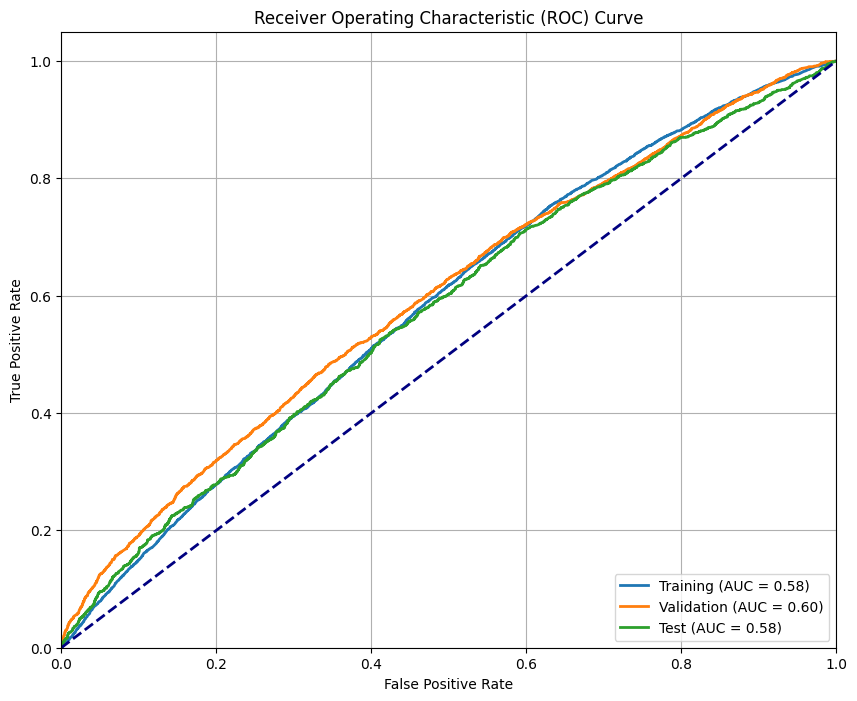

In [77]:
# Datasets for evaluation
datasets = {
    'Training': (X_train, y_train),
    'Validation': (X_valid, y_valid),
    'Test': (X_test, y_test)
}

plt.figure(figsize=(10, 8))

for name, (X, y) in datasets.items():
    y_pred_prob = logreg.predict_proba(X)[:, 1]  # Probability of the positive class
    roc_auc_value = roc_auc_score(y, y_pred_prob)
    fpr, tpr, _ = roc_curve(y, y_pred_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_value:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### Confusion matrix on each data set

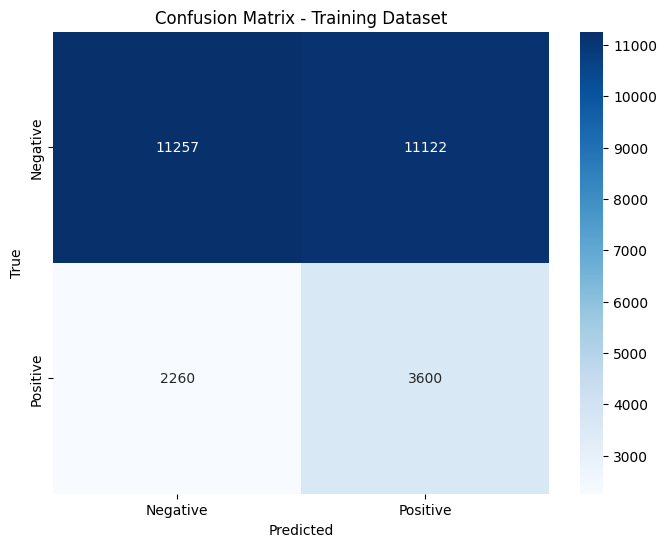

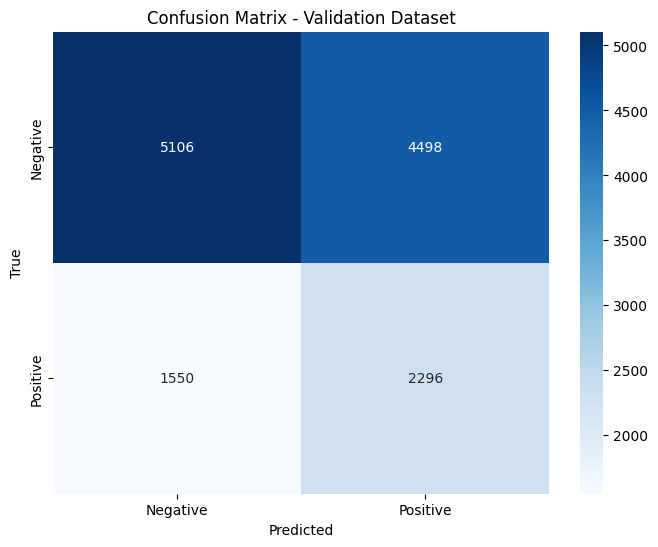

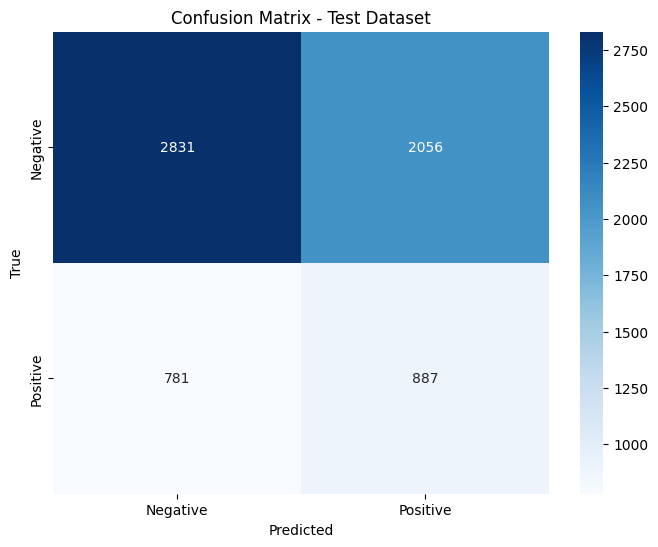

In [78]:
# Datasets for evaluation
datasets = {
    'Training': (X_train, y_train),
    'Validation': (X_valid, y_valid),
    'Test': (X_test, y_test)
}

for name, (X, y) in datasets.items():
    # Predict binary outcomes
    y_pred = logreg.predict(X)
    
    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name} Dataset')
    plt.show()

#### Classification/Model performance report

In [79]:
# Print model classification report
for name, (X, y) in datasets.items():
    y_pred = logreg.predict(X)
    print(f"Classification Report - {name} Dataset")
    print(classification_report(y, y_pred, target_names=['Negative', 'Positive']))


Classification Report - Training Dataset
              precision    recall  f1-score   support

    Negative       0.83      0.50      0.63     22379
    Positive       0.24      0.61      0.35      5860

    accuracy                           0.53     28239
   macro avg       0.54      0.56      0.49     28239
weighted avg       0.71      0.53      0.57     28239

Classification Report - Validation Dataset
              precision    recall  f1-score   support

    Negative       0.77      0.53      0.63      9604
    Positive       0.34      0.60      0.43      3846

    accuracy                           0.55     13450
   macro avg       0.55      0.56      0.53     13450
weighted avg       0.64      0.55      0.57     13450

Classification Report - Test Dataset
              precision    recall  f1-score   support

    Negative       0.78      0.58      0.67      4887
    Positive       0.30      0.53      0.38      1668

    accuracy                           0.57      6555
   macr

#### Precision recall curve on each data set

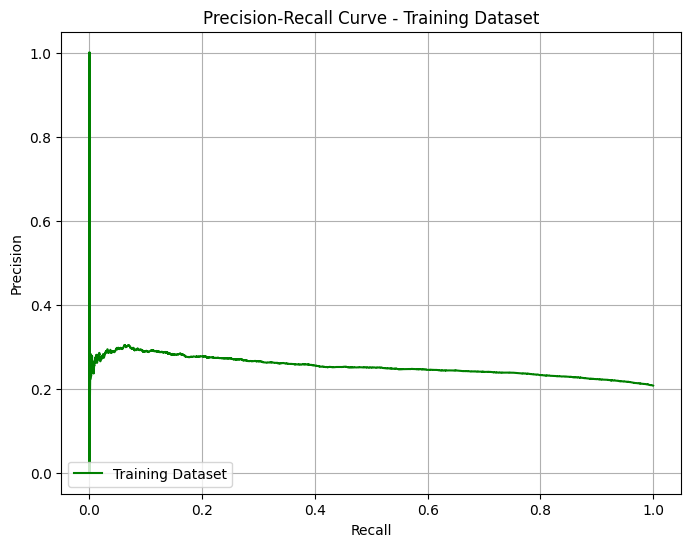

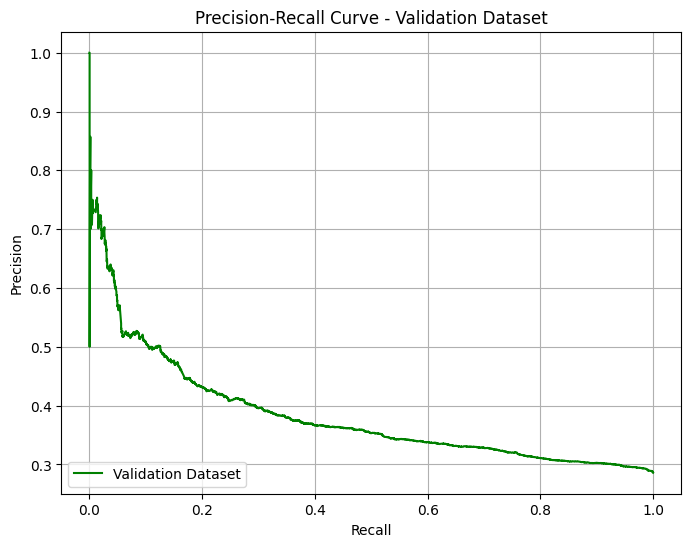

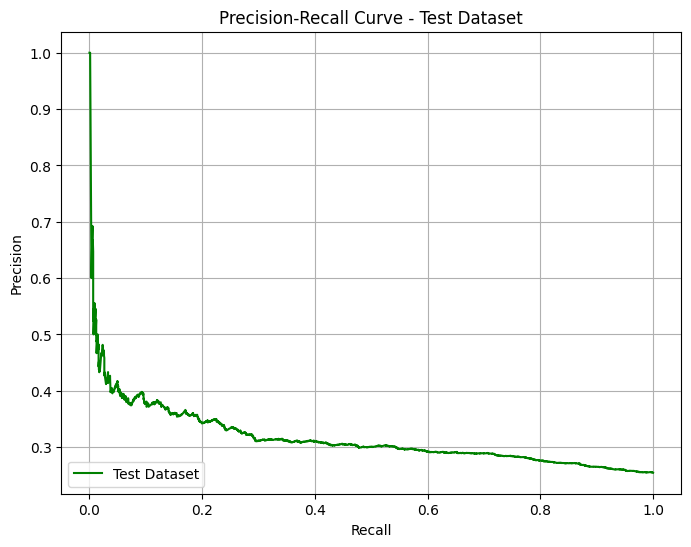

In [80]:
# Datasets for evaluation
datasets = {
    'Training': (X_train, y_pred_train, y_train),
    'Validation': (X_valid, y_pred_valid, y_valid),
    'Test': (X_test, y_pred_test, y_test)
}

for name, (X, y_prob, y) in datasets.items():
    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y, y_prob)
    
    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', label=f'{name} Dataset')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name} Dataset')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


#### Compute average precision recall score on each data set

In [81]:
for name, (X, y_prob, y) in datasets.items():
    ap_score = average_precision_score(y, y_prob)
    print(f"Average Precision (AP) - {name} Dataset: {ap_score:.4f}")


Average Precision (AP) - Training Dataset: 0.2525
Average Precision (AP) - Validation Dataset: 0.3829
Average Precision (AP) - Test Dataset: 0.3150


#### Plot learning curve for train and valid sets

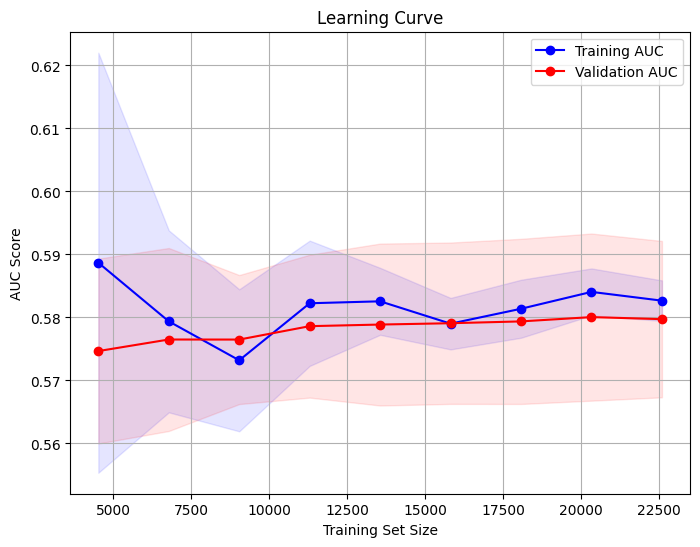

In [82]:
# Define model with appropriate parameters
# model = LogisticRegression(max_iter=1000, penalty='l2', C=0.1, class_weight='balanced', random_state=42)
model = logreg
# Compute learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation for AUC scores
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training AUC')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation AUC')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


#### Sample score outputs

In [83]:
df_train['score'] = logreg.predict_proba(X_train)[:, 1]
ranked_train = df_train.sort_values(by='score', ascending=False)
print(ranked_train[['BIGACCOUNTID', 'score']].head(10))



       BIGACCOUNTID     score
31841       5693624  0.670682
15732       5779252  0.669134
32065       5820333  0.669134
14277       5818205  0.668146
29544       5940630  0.667774
176         5973304  0.667749
46558       5756775  0.667749
39547       5987855  0.667749
47831       5781328  0.666785
18241       5944661  0.666575


In [84]:
df_valid['score'] = logreg.predict_proba(X_valid)[:, 1]
ranked_valid = df_valid.sort_values(by='score', ascending=False)
print(ranked_valid[['BIGACCOUNTID', 'score']].head(10))


       BIGACCOUNTID     score
16501       6123111  0.670682
38976       6269929  0.669741
231         6258193  0.667774
8763        6124574  0.667774
22303       6252952  0.667774
2341        6146593  0.667749
13481       6144668  0.666194
20936       6146603  0.665603
7223        6146781  0.665584
5729        6121386  0.665584


In [85]:
df_test['score'] = logreg.predict_proba(X_test)[:, 1]
ranked_test = df_test.sort_values(by='score', ascending=False)
print(ranked_test[['BIGACCOUNTID', 'score']].head(10))


       BIGACCOUNTID     score
5532        6391586  0.670682
1975        6391693  0.659324
5303        6433898  0.654004
26278       6484742  0.654004
21688       6377546  0.654004
13944       6377546  0.654004
26531       6438939  0.654004
34381       6470399  0.654004
28253       6445087  0.654004
49954       6402398  0.654004


#### Coefficients bar chart

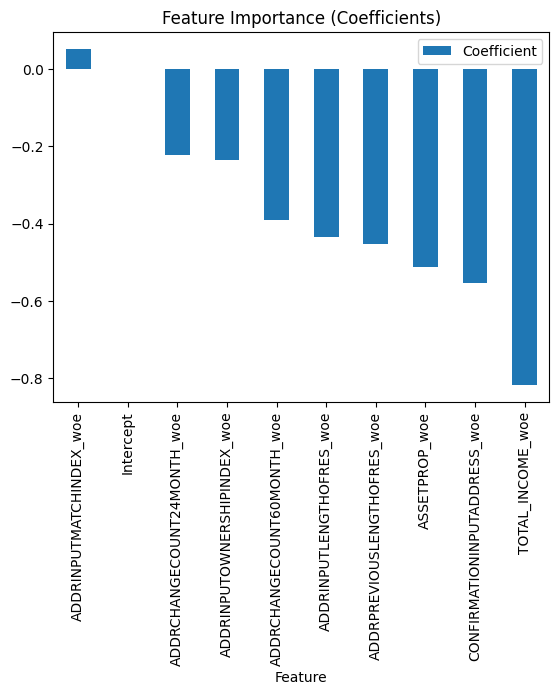

In [86]:
coefficients.sort_values(by='Coefficient', ascending=False).plot.bar(x='Feature', y='Coefficient')
plt.title("Feature Importance (Coefficients)")
plt.show()


#### Mean cross validation AUC scores

In [87]:
cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean Cross-validation AUC: {cv_scores.mean():.4f}")


Cross-validation AUC scores: [0.592284   0.55670548 0.63032379 0.58299726 0.54178746]
Mean Cross-validation AUC: 0.5808


#### Compute and plot optimal threshold recall 

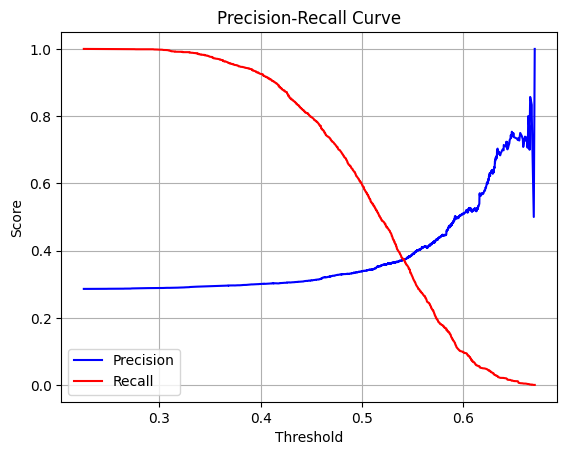

Optimal Threshold for Recall 0.7: 0.22532585874188193


In [88]:
# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_valid)

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Example: Choose threshold for a desired recall level (e.g., 0.7)
desired_recall = 0.7
optimal_threshold = thresholds[np.argmax(recall >= desired_recall)]
print(f"Optimal Threshold for Recall {desired_recall}: {optimal_threshold}")


In [89]:
# Baseline model: 
#     Logistic Regression with regularization parameter of C=0.1
#     Baseline metrics: 
#     AUC: Train = .6493, Valid = .5897, Test = .5746
#     LogLoss: Train = .6551, Valid = .6409, Test = .6289
#     Classification Report Poor recall and F2 for defaults. Indicating imbalance
#     KS: Train = .7623, Valid = .7141, Test = .7455


# Steps taken trying to improve model performance:
# 1. Ran multiple model variations applying various feature combinations, iteratively removing features based on low IV scores
# 2. Added class weight balancing to penalize incorrect positives (defaults) and L2
# 3. Reduced regularization strength from 0.1 to 0.05 to mitigate overfitting
#     Result: Regularization change had negligible impact on AUC (Train: 0.6490, Validation: 0.5904, Test: 0.5743)
#     KS, Log Loss remained stable with only minor fluctuations within expected variance.
#     This suggests regularization changes had no impact on improving model performance and may be due to features
# 4. Added SMOTE to further balance class weights, equalizing num of pos. and neg. samples in training data. 
#     This balanced the class distribution from ~76:24 to 50:50
#     Result: Slight decrease in AUC (Train: 0.6483, Validation: 0.5898, Test: 0.5723). 
#     Decrease in LogLoss (Train: 0.6552, Validation: 0.6405, Test: 0.6303).
#     KS changes showed no meaningful improvement
#     Negligible changes to precision recall. The decrease in AUC and and precision recall
#     scores may be due to noise introduced by SMOTE. Persistent poor recall and F1 indicate SMOTE did not crete informative (syntehtic) samples that 
#     improved predictiveness.
# 5. Threshold tuning: Adjusted the classification threshold to improve recall for defaults. 
#     Result: Recall improved but at the cost of worsening precision. Precision dropped significantly. F1 marginally improved for defaults 
#     due to higher recall, but overall performance remained poor.
#     Threshold tuning appeared to work shifting focus to recall, but the trade off in precision and F1 worsened model predictiveness.

# Consistently low AUC and precision recall across all data sets indicate weak separatability between classes. Model struggles to achieve high recall 
# for defaults, even after threshold tuning and SMOTE. No meaningful changes improved performance, indicating features likely are too weak to predict on.


In [90]:
# Initial feature list:
#     'SUM_OF_COMBINED_INCOME',
#     'INT_N_EMPS',
#     'PTI',
#     'VEHICLEYEAR',
#     'LTV',
#     'FLTADVANCE',
#     'BIGMILEAGE_ODOMETER',
#     'INT_N_EMPS',
#     'TOTAL_INCOME',
#     'FLTDOWNCASH',
#     'DTI',
#     'NUMOFDEBTS',
#     'INQUIRYBANKING12MONTH',
#     'INQUIRYAUTO12MONTH',
#     'ADDRCHANGECOUNT12MONTH',
#     'ADDRCHANGECOUNT24MONTH',
#     'ADDRCHANGECOUNT60MONTH',
#     'ADDRCURRENTLENGTHOFRES',
#     'ADDRCURRENTTIMEOLDEST',
#     'ADDRINPUTLENGTHOFRES',
#     'ADDRPREVIOUSLENGTHOFRES',
#     'ADDRINPUTSUBJECTCOUNT',
#     'ADDRSTABILITYINDEX',
#     'ADDRONFILECOUNT',
#     'CONFIRMATIONINPUTADDRESS',
#     'ADDRINPUTTIMENEWEST',
#     'ADDRINPUTTIMEOLDEST',
#     'ADDRCURRENTTIMENEWEST',
#     'EVICTIONCOUNT',
#     'INQUIRYCOLLECTIONS12MONTH',
#     'ADDRCHANGECOUNT06MONTH'

# 2nd model iteration: Removed several application and collateral features (VEHICLEYEAR, SUM_OF_COMBINED_INCOME, INT_N_EMPS, PTI).
# Decision was made to remove some structural features. 

# 3rd model iteration: Removed LN features (ADDRCURRENTTIMEOLDEST, ADDRCHANGECOUNT12MONTH, CONFIRMATIONINPUTADDRESS, 
#                     ADDRINPUTTIMENEWEST, ADDRINPUTTIMEOLDEST, ADDRCURRENTTIMENEWEST, ADDRINPUTSUBJECTCOUNT, ADDRCHANGECOUNT06MONTH)
# Removed additional features for explainability and simplification. 
# Features removed were either deemed as redundant or not informative enough to retain. Model performance sub-optimal, auc range .60-.63 range. 
# False positive recall ranged in the 30-40% area

# 4th model iteration: Removed features (BIGMILEAGE_ODOMETER, FLTADVANCE, LTV, ADDRPREVIOUSLENGTHOFRES, INQUIRYCOLLECTIONS12MONTH, EVICTIONCOUNT)
# Additionally removed any remaining structural features per Steve. Performance and predicability dropped. Further iterated through random feature 
# selection and model fitting trying to increase performance. AUC remained .56-.59 on valid and test sets. False positive recall still the same

# 5-6th model iterations: Reran switching out various LN features.
# Added class weight balancing, increased penalization for incorrect classifications, added SMOTE to help with overfitting/class balance. 
# AUC remained in the same range, slightly improved but false positives on the default class stayed the same

# 7-8th model iteration (current) feature list: 
# (TOTAL_INCOME, FLTDOWNCASH, DTI, INQUIRYBANKING12MONTH, ADDRCHANGECOUNT24MONTH, ADDRCHANGECOUNT60MONTH, ADDRCURRENTLENGTHOFRES, ADDRINPUTLENGTHOFRES)
# Continued refitting model, performance metrics improved slightly (auc in the low 6's). False positives ranged 25-35%
# Standardized overall score output to match TUX model score range

# 9-11th model iterations: 
# feature list (TOTAL_INCOME, DTI, INQUIRYBANKING12MONTH, ADDRCHANGECOUNT24MONTH, ADDRCHANGECOUNT60MONTH, ADDRINPUTLENGTHOFRES, 
# ADDRPREVIOUSLENGTHOFRES, CONFIRMATIONINPUTADDRESS). 
# Continued training model on tighter penalization, balancing parameters. Reduced regularization for overfitting. Performance metrics did not improve. 
# Changed imputation on Total_Income from mode (3120) to min income value (2150). 
# Done to resolve WOE binning issues for imputed population. Bin created non-linear woe value and small bin range. 
# Result - auc ranged .60-.64, false positive recall remained the same. 

# 12th iteration:
# Feature list TOTAL_INCOME(with new imputation values), DTI_Eng, INQUIRYBANKING12MONTH, ADDRCHANGECOUNT24MONTH, ADDRCHANGECOUNT60MONTH, 
# ADDRINPUTLENGTHOFRES, ADDRPREVIOUSLENGTHOFRES, CONFIRMATIONINPUTADDRESS
# Resampled model features including EVICTIONCOUNT, ADDRCURRENTLENGTHOFRES, INQUIRYAUTO12MONTH, ADDRESSINPUTSUBJECTCOUNT
# Engineered DTI removing our payment from the tempstatic DTI value in data set. Eng_DTI only looking at debts on cbr that we used
# model performance suffered. AUC .56-.62 range. 
# Refit and calibrated to test possible over-penalization and class balancing. Model performance did not improve 

# 13th-14th Iteration:
# Imputed DTI_Eng outliers to 0.30. Model performance stayed the same as 12th
# Features added: ADDRCURRENTDWELLTYPE, ADDRCURRENTOWNERSHIPINDEX, ADDRINPUTMATCHINDEX, ADDRINPUTOWNERSHIPINDEX, ADDRINPUTPHONECOUNT, ADDRINPUTPROBLEMS,
#          ASSETPROP, SHORTTERMLOANREQUEST12MONTH, SHORTTERMLOANREQUEST24MONTH
# AUC stayed the same through both runs (mid-high .50s). Accuracy and precision recall remained insufficient.




In [91]:
# Build code in v5 to incorporate pickled functions and replicable code for integration

# update model output to include logodds score and adjusted logodds as needed

# Determine how the model is calculating logodds, for example, no default or bad rate was specified. So what is the model calculating logodds on?

In [92]:
    # 'INQB12M'
    # 'INQA12M'
    # 'ADRCHCT24M'
    # 'ADRCHCT60M'
    # 'ADRINLOR'
    # 'ADRPRVSLOR'
    # 'CONINADR'
    # 'ADRINMIX'
    # 'ADRINOWNIX'
    # 'ASSETPROP'